In [29]:
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import ensemble
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.utils import resample
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
sns.set_style('darkgrid')

In [2]:
# Load up the data.
#ga stands for gender/age
ga_train = pd.read_csv('gender_age_train.csv')
ga_test = pd.read_csv('gender_age_test.csv' )
# 
phone_brands = pd.read_csv('phone_brand_device_model.csv')
# Get rid of duplicate device ids in phone
phone_brands = phone_brands.drop_duplicates('device_id',keep='first')
# Location data
events = pd.read_csv('events.csv', usecols = ['event_id', 'device_id'])
app_events = pd.read_csv('app_events.csv', usecols=['event_id','app_id','is_active'],
                        dtype={'is_active':bool})
app_labels = pd.read_csv('app_labels.csv')
label_cats = pd.read_csv('label_categories.csv', index_col='label_id',squeeze=True)

# Exploratory Data Analysis

In [3]:
print('Shape of ga_train data set:')
print(ga_train.shape)
ga_train.head()

Shape of ga_train data set:
(74645, 4)


,device_id,gender,age,group
0,-8076087639492063270,M,35,M32-38
1,-2897161552818060146,M,35,M32-38
2,-8260683887967679142,M,35,M32-38
3,-4938849341048082022,M,30,M29-31
4,245133531816851882,M,30,M29-31


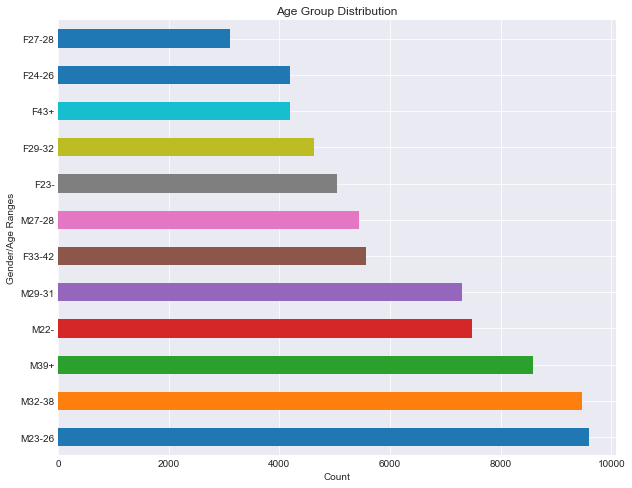

In [4]:
# Distribution of age based users.
fig,ax = plt.subplots(figsize=(10,8))
ga_train.group.value_counts().plot(kind='barh')
plt.title('Age Group Distribution')
plt.ylabel('Gender/Age Ranges')
plt.xlabel('Count');

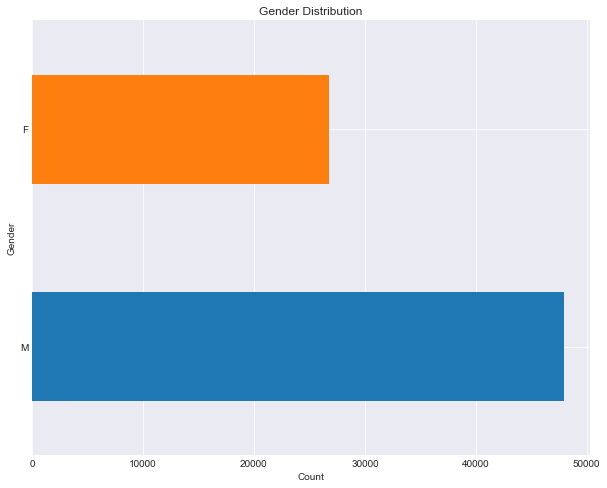

In [5]:
# Gender Distribution
fig,ax = plt.subplots(figsize=(10,8))
ga_train.gender.value_counts().plot(kind='barh')
plt.title('Gender Distribution')
plt.xlabel('Count')
plt.ylabel('Gender');

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


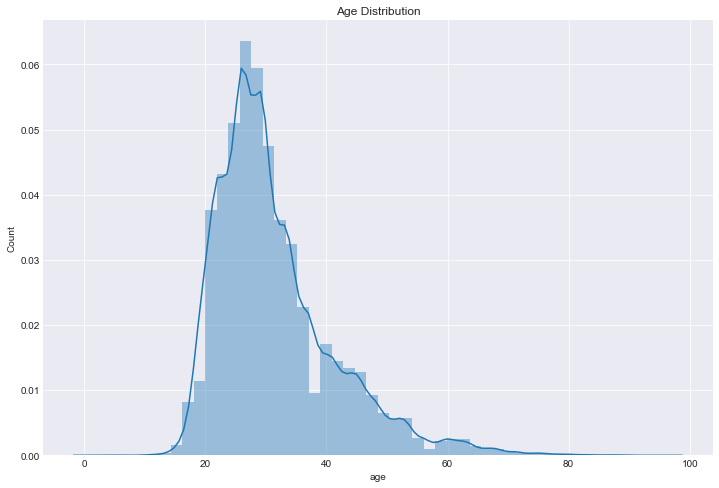

In [6]:
# Age Distribution
fig,ax = plt.subplots(figsize=(12,8))
plt.title('Age Distribution')
plt.xlabel('Ages')
plt.ylabel('Count')
sns.distplot(ga_train.age);

In [7]:
print('Shape of phone brands data set:')
print(phone_brands.shape)
phone_brands.head()

Shape of phone brands data set:
(186716, 3)


,device_id,phone_brand,device_model
0,-8890648629457979026,小米,红米
1,1277779817574759137,小米,MI 2
2,5137427614288105724,三星,Galaxy S4
3,3669464369358936369,SUGAR,时尚手机
4,-5019277647504317457,三星,Galaxy Note 2


In [8]:
print('Number of unique brands:')
print(phone_brands.phone_brand.nunique())

print('\nNumber of unique models:')
print(phone_brands.device_model.nunique())

Number of unique brands:
131

Number of unique models:
1599


In [9]:
# Check to see if there is over representation of any one brand. 
device_count = phone_brands.groupby(['device_model'])['phone_brand'].apply(pd.Series.nunique)
device_count.value_counts()

1    1545
2      43
3       8
4       3
Name: phone_brand, dtype: int64

In [10]:
# App events overlook
print('shape of events data set:')
print(app_events.shape)
app_events.head(25)

shape of events data set:
(32473067, 3)


,event_id,app_id,is_active
0,2,5927333115845830913,True
1,2,-5720078949152207372,False
2,2,-1633887856876571208,False
3,2,-653184325010919369,True
4,2,8693964245073640147,True
5,2,4775896950989639373,True
6,2,-8022267440849930066,False
7,2,9112463267739110219,False
8,2,-3725672010020973973,False
9,2,7167114343576723123,True


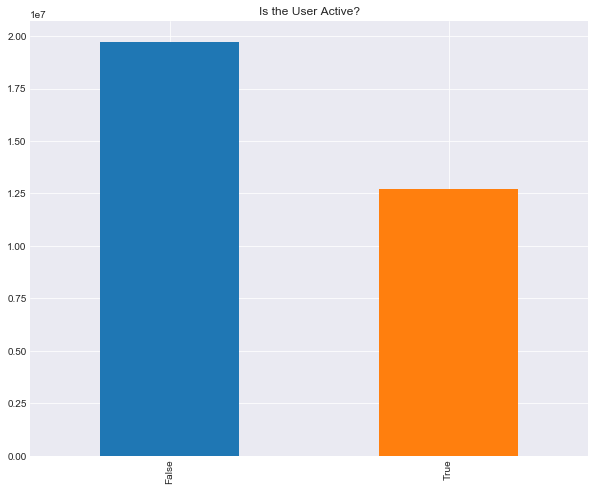

In [11]:
fig,ax = plt.subplots(figsize=(10,8))
plt.title('Is the User Active?')
app_events['is_active'].value_counts().plot(kind='bar');

In [12]:
print('Shape of events:')
print(events.shape)
events.head()

Shape of events:
(3252950, 2)


,event_id,device_id
0,1,29182687948017175
1,2,-6401643145415154744
2,3,-4833982096941402721
3,4,-6815121365017318426
4,5,-5373797595892518570


# Data Exploration (No Graphs)

In [102]:
# Check numerical value of age groups
ga_train.group.value_counts()

M23-26    9605
M32-38    9476
M39+      8581
M22-      7488
M29-31    7309
F33-42    5561
M27-28    5445
F23-      5050
F29-32    4628
F43+      4194
F24-26    4190
F27-28    3118
Name: group, dtype: int64

In [103]:
# Re-import app_events for the binary output of is_active
app_events2 = pd.read_csv('app_events.csv', usecols=['event_id','app_id','is_active'])

In [104]:
device_apps = (
    app_events2
    
     # Merge on event_id
    .merge(events, how = 'left', left_on = 'event_id', right_on = 'event_id')
    
     # event_id itself is not interesting
    .drop('event_id', axis = 1)
    
     # Because the events correspond to more than just
     # being installed, there are many duplicates
    .drop_duplicates()
)

# Our data now looks like this
device_apps.head()

,app_id,is_active,device_id
0,5927333115845830913,1,-6401643145415154744
1,-5720078949152207372,0,-6401643145415154744
2,-1633887856876571208,0,-6401643145415154744
3,-653184325010919369,1,-6401643145415154744
4,8693964245073640147,1,-6401643145415154744


In [105]:
device_apps.shape

(2840343, 3)

In [106]:
# Encode the device_model and phone_brand to use as a feature.
phone_brands.head()

,device_id,phone_brand,device_model,brand_and_model,encoded_model
0,-8890648629457979026,小米,红米,小米红米,858
1,1277779817574759137,小米,MI 2,小米MI 2,843
2,5137427614288105724,三星,Galaxy S4,三星Galaxy S4,371
3,3669464369358936369,SUGAR,时尚手机,SUGAR时尚手机,166
4,-5019277647504317457,三星,Galaxy Note 2,三星Galaxy Note 2,347


In [107]:
# It seems like some brands don't have specific model names.
print('Number of distinct model names: ' + str(phone_brands.groupby(['device_model']).size().shape[0]))
print('Number of distinct brand+model names: ' + str(phone_brands.groupby(['phone_brand','device_model']).size().shape[0]))

Number of distinct model names: 1599
Number of distinct brand+model names: 1667


In [108]:
# Combine the two columns
phone_brands['brand_and_model'] = phone_brands['phone_brand'].astype(str) + phone_brands['device_model']

# Build numerical labels for our models
modelencoder = LabelEncoder().fit(phone_brands['brand_and_model'])

# Store in a new column
phone_brands['encoded_model'] = modelencoder.transform(phone_brands['brand_and_model'])

In [109]:
# Take a look to see what phone_brands look like now.
phone_brands.head(50)

,device_id,phone_brand,device_model,brand_and_model,encoded_model
0,-8890648629457979026,小米,红米,小米红米,858
1,1277779817574759137,小米,MI 2,小米MI 2,843
2,5137427614288105724,三星,Galaxy S4,三星Galaxy S4,371
3,3669464369358936369,SUGAR,时尚手机,SUGAR时尚手机,166
4,-5019277647504317457,三星,Galaxy Note 2,三星Galaxy Note 2,347
5,3238009352149731868,华为,Mate,华为Mate,671
6,-3883532755183027260,小米,MI 2S,小米MI 2S,846
7,-2972199645857147708,华为,G610S,华为G610S,648
8,-5827952925479472594,小米,MI One Plus,小米MI One Plus,852
9,-8262508968076336275,vivo,S7I,vivoS7I,214


In [110]:
# Check to see if encoding process has followed through correctly. 
phone_brands.encoded_model.nunique()

1667

# Merging Files Together

In [111]:
print(app_labels.shape)
app_labels.head()

(459943, 2)


,app_id,label_id
0,7324884708820027918,251
1,-4494216993218550286,251
2,6058196446775239644,406
3,6058196446775239644,407
4,8694625920731541625,406


In [112]:
print(app_events.shape)
app_events.head()

(32473067, 3)


,event_id,app_id,is_active
0,2,5927333115845830913,True
1,2,-5720078949152207372,False
2,2,-1633887856876571208,False
3,2,-653184325010919369,True
4,2,8693964245073640147,True


Previously, my kernel would crash after merging the two files together without using drop dupes. My solution is to drop duplicates and thats why it is spelled 'ddupe' for drop dupe. The reason the kernel would crash shortly after the creation of the new file is due to the fact that the rows grew from 32 million to over 200 million. 

In [113]:
# Experimenting with how to handle dupes. 
# Adding labels to app_events
apps_labeled = pd.merge(app_labels,
                       app_events[['app_id', 'is_active']],
                       on='app_id').dropna().drop_duplicates()

print(apps_labeled.shape)
apps_labeled.head()

(117374, 3)


,app_id,label_id,is_active
0,7324884708820027918,251,False
6,7324884708820027918,251,True
11,7324884708820027918,691,False
17,7324884708820027918,691,True
22,7324884708820027918,751,False


In [114]:
# Merge ga_train and device_apps
ga_apps = pd.merge(ga_train,
                  device_apps[['app_id', 'is_active', 'device_id']],
                  on='device_id').dropna()
#Shape of ga_apps
print(ga_apps.shape)

# Show how the new df looks.
ga_apps.head()

(1097150, 6)


,device_id,gender,age,group,app_id,is_active
0,-8260683887967679142,M,35,M32-38,4287147352639325907,0
1,-8260683887967679142,M,35,M32-38,-4085686983594738208,0
2,-8260683887967679142,M,35,M32-38,6324194957022958681,0
3,-8260683887967679142,M,35,M32-38,-8687507491028761317,0
4,-8260683887967679142,M,35,M32-38,877288515501232570,1


In [115]:
# Merge the previous data set with brands now. 
ga_apps_brands = pd.merge(ga_apps,
                         phone_brands[['device_id', 'encoded_model']],
                         on='device_id').dropna()
#Show me the shape
print(ga_apps_brands.shape)

#Look at how the data looks.
ga_apps_brands.head()

(1097150, 7)


,device_id,gender,age,group,app_id,is_active,encoded_model
0,-8260683887967679142,M,35,M32-38,4287147352639325907,0,843
1,-8260683887967679142,M,35,M32-38,-4085686983594738208,0,843
2,-8260683887967679142,M,35,M32-38,6324194957022958681,0,843
3,-8260683887967679142,M,35,M32-38,-8687507491028761317,0,843
4,-8260683887967679142,M,35,M32-38,877288515501232570,1,843


In [116]:
# Putting all of the data sets together.
ga_apps_labeled_brands = pd.merge(ga_apps_brands,
                                 apps_labeled[['app_id', 'label_id']],
                                 on='app_id').dropna().drop_duplicates()
#Show me the shape
print(ga_apps_labeled_brands.shape)

#Look at how the data looks.
ga_apps_labeled_brands.head()

(7034111, 8)


,device_id,gender,age,group,app_id,is_active,encoded_model,label_id
0,-8260683887967679142,M,35,M32-38,4287147352639325907,0,843,713
2,-8260683887967679142,M,35,M32-38,4287147352639325907,0,843,704
4,-8260683887967679142,M,35,M32-38,4287147352639325907,0,843,548
6,8761770737926125955,F,22,F23-,4287147352639325907,0,226,713
8,8761770737926125955,F,22,F23-,4287147352639325907,0,226,704


In [117]:
# Convert gender into a binary output
ga_apps_labeled_brands['gender'] = ga_apps_labeled_brands['gender'].apply(lambda x: 1 if x == 'M' else 0 )

In [118]:
ga_apps_labeled_brands.gender.value_counts()

1    4942458
0    2091653
Name: gender, dtype: int64

In [119]:
# Make another copy since the previous copy has already been dummified.
# Putting all of the data sets together.
ga_apps_labeled_brands2 = pd.merge(ga_apps_brands,
                                 apps_labeled[['app_id', 'label_id']],
                                 on='app_id').dropna().drop_duplicates()

# Convert gender into a binary output
ga_apps_labeled_brands2['gender'] = ga_apps_labeled_brands2['gender'].apply(lambda x: 1 if x == 'M' else 0 )

#Show me the shape
print(ga_apps_labeled_brands2.shape)

#Look at how the data looks.
ga_apps_labeled_brands2.head()

(7034111, 8)


,device_id,gender,age,group,app_id,is_active,encoded_model,label_id
0,-8260683887967679142,1,35,M32-38,4287147352639325907,0,843,713
2,-8260683887967679142,1,35,M32-38,4287147352639325907,0,843,704
4,-8260683887967679142,1,35,M32-38,4287147352639325907,0,843,548
6,8761770737926125955,0,22,F23-,4287147352639325907,0,226,713
8,8761770737926125955,0,22,F23-,4287147352639325907,0,226,704


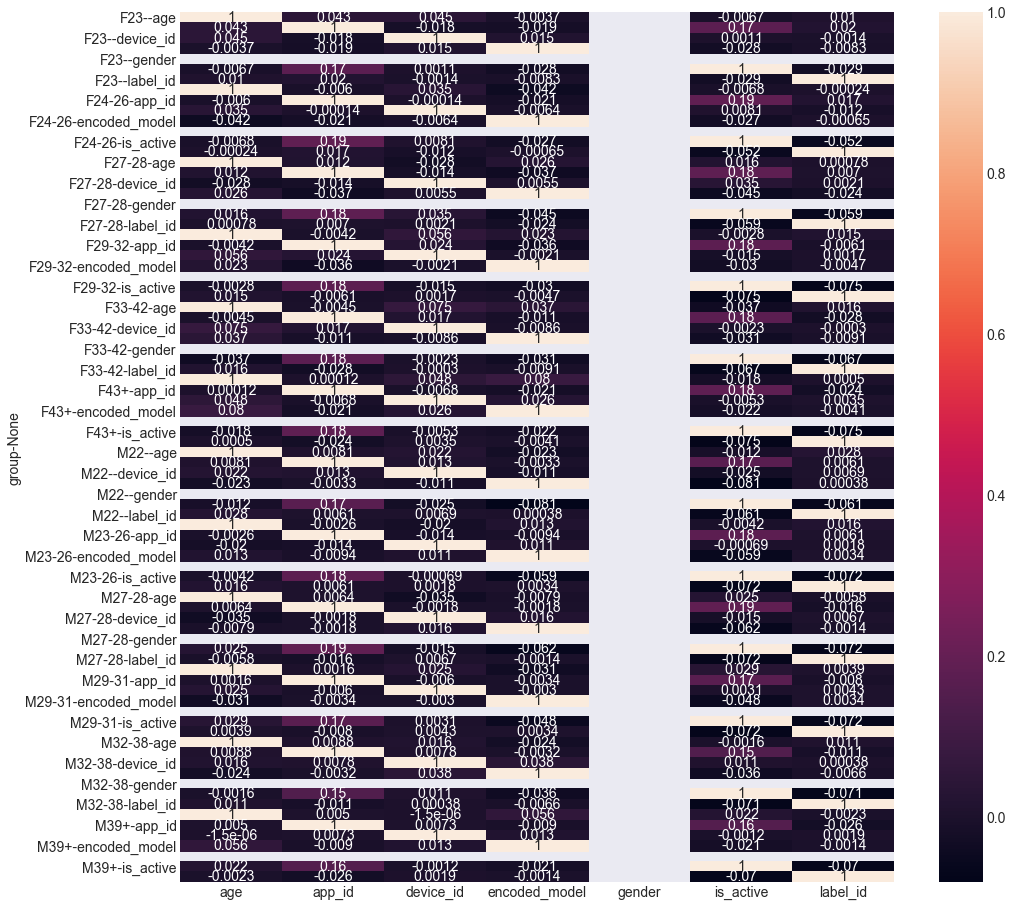

In [120]:
# Create a heatmap to see if there is any multicollinearity.
# Make a smaller data set to use because 7 million rows took too long.
group_data_mini = ga_apps_labeled_brands2[:600000]

# Group by group since that's the output that we care about.
group_data_mini = group_data_mini.groupby('group')

plt.rcParams['figure.figsize'] = (16.0, 16.0)
plt.rcParams.update({'font.size': 14})
sns.heatmap(group_data_mini.corr(), annot=True);

# Creating Dummies

In [121]:
# Convert label_id into a continuous variable
# even though it's numerical, it hasn't been standardized 
type_dummies = pd.get_dummies(ga_apps_labeled_brands['label_id'])

# Concatenate the dummies with the original data set.
ga_apps_labeled_brands = pd.concat([ga_apps_labeled_brands, type_dummies], axis=1)

print(ga_apps_labeled_brands.shape)

ga_apps_labeled_brands.head()

(7034111, 493)


,device_id,gender,age,group,app_id,is_active,encoded_model,label_id,2,4,...,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021
0,-8260683887967679142,1,35,M32-38,4287147352639325907,0,843,713,0,0,...,0,0,0,0,0,0,0,0,0,0
2,-8260683887967679142,1,35,M32-38,4287147352639325907,0,843,704,0,0,...,0,0,0,0,0,0,0,0,0,0
4,-8260683887967679142,1,35,M32-38,4287147352639325907,0,843,548,0,0,...,0,0,0,0,0,0,0,0,0,0
6,8761770737926125955,0,22,F23-,4287147352639325907,0,226,713,0,0,...,0,0,0,0,0,0,0,0,0,0
8,8761770737926125955,0,22,F23-,4287147352639325907,0,226,704,0,0,...,0,0,0,0,0,0,0,0,0,0


# Addressing Class Imbalance

In [122]:
# Take a look at the distribution of the group values.
ga_apps_labeled_brands.group.value_counts()

M32-38    1185421
M39+      1107632
M23-26     817660
M29-31     810956
M27-28     530780
F33-42     517420
M22-       490009
F43+       391188
F29-32     368450
F23-       303034
F24-26     265262
F27-28     246299
Name: group, dtype: int64

In [123]:
# Downsampling the gender/age training set to 50000.
ga_m_youngest = ga_apps_labeled_brands[ga_apps_labeled_brands.group=='M22-']
ga_m_younger = ga_apps_labeled_brands[ga_apps_labeled_brands.group=='M23-26']
ga_m_young = ga_apps_labeled_brands[ga_apps_labeled_brands.group=='M27-28']
ga_m_old = ga_apps_labeled_brands[ga_apps_labeled_brands.group=='M29-31']
ga_m_older = ga_apps_labeled_brands[ga_apps_labeled_brands.group=='M32-38']
ga_m_oldest = ga_apps_labeled_brands[ga_apps_labeled_brands.group=='M39+']
ga_f_youngest = ga_apps_labeled_brands[ga_apps_labeled_brands.group=='F23-']
ga_f_younger = ga_apps_labeled_brands[ga_apps_labeled_brands.group=='F24-26']
ga_f_young = ga_apps_labeled_brands[ga_apps_labeled_brands.group=='F27-28']
ga_f_old = ga_apps_labeled_brands[ga_apps_labeled_brands.group=='F29-32']
ga_f_older = ga_apps_labeled_brands[ga_apps_labeled_brands.group=='F33-42']
ga_f_oldest = ga_apps_labeled_brands[ga_apps_labeled_brands.group=='F43+']

# Downsample majority class
ga_m_older_downsampled = resample(ga_m_older, 
                                 replace=True,     # sample with replacement
                                 n_samples=50000)

ga_m_oldest_downsampled = resample(ga_m_oldest, 
                                 replace=True,     # sample with replacement
                                 n_samples=50000)

ga_m_younger_downsampled = resample(ga_m_younger, 
                                 replace=True,     # sample with replacement
                                 n_samples=50000)

ga_m_youngest_downsampled = resample(ga_m_youngest, 
                                 replace=True,     # sample with replacement
                                 n_samples=50000)  
 
ga_m_old_downsampled = resample(ga_m_old, 
                                 replace=True,     # sample with replacement
                                 n_samples=50000) 

ga_f_older_downsampled = resample(ga_f_older, 
                                 replace=True,     # sample with replacement
                                 n_samples=50000) 

ga_m_young_downsampled = resample(ga_m_young, 
                                 replace=True,     # sample with replacement
                                 n_samples=50000) 

ga_f_youngest_downsampled = resample(ga_f_youngest, 
                                 replace=True,     # sample with replacement
                                 n_samples=50000) 

ga_f_old_downsampled = resample(ga_f_old, 
                                 replace=True,     # sample with replacement
                                 n_samples=50000)

ga_f_oldest_downsampled = resample(ga_f_oldest, 
                                 replace=True,     # sample with replacement
                                 n_samples=50000)


ga_f_younger_downsampled = resample(ga_f_younger, 
                                 replace=True,     # sample with replacement
                                n_samples=50000)

ga_f_young_downsampled = resample(ga_f_young, 
                                 replace=True,     # sample with replacement
                                 n_samples=50000)

# Combine downsampled majority class 
ga_apps_labeled_brands_resampled = pd.concat([ga_m_younger_downsampled, ga_m_older_downsampled,
                               ga_m_oldest_downsampled, ga_m_youngest_downsampled,
                               ga_m_old_downsampled, ga_f_older_downsampled,
                               ga_m_young_downsampled, ga_f_youngest_downsampled,
                               ga_f_old_downsampled, ga_f_oldest_downsampled,
                               ga_f_younger_downsampled, ga_f_young_downsampled])
 
# Display new class counts
ga_apps_labeled_brands_resampled.group.value_counts()

M23-26    50000
F29-32    50000
M27-28    50000
F43+      50000
M39+      50000
M32-38    50000
F23-      50000
F27-28    50000
M22-      50000
F33-42    50000
F24-26    50000
M29-31    50000
Name: group, dtype: int64

In [124]:
# Shape
print(ga_apps_labeled_brands_resampled.shape)

# Head
ga_apps_labeled_brands_resampled.head()

(600000, 493)


,device_id,gender,age,group,app_id,is_active,encoded_model,label_id,2,4,...,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021
13785629,-2273897394403963041,1,25,M23-26,-4788816465345944364,0,121,796,0,0,...,0,0,0,0,0,0,0,0,0,0
3117501,-1133913387809768728,1,23,M23-26,2577600876485430729,0,1655,302,0,0,...,0,0,0,0,0,0,0,0,0,0
2732416,-7218893809278216266,1,24,M23-26,-7377004479023402858,0,847,183,0,0,...,0,0,0,0,0,0,0,0,0,0
11432256,3395523396744541056,1,25,M23-26,-1633908186354644707,0,241,960,0,0,...,0,0,0,0,0,0,0,0,0,0
10779188,37987981111678137,1,25,M23-26,7378912078908392888,1,736,713,0,0,...,0,0,0,0,0,0,0,0,0,0


# Train Test Split

In [138]:
# Create X and y 
X = ga_apps_labeled_brands_resampled.drop(['group', 'app_id'], axis=1)
Y = ga_apps_labeled_brands_resampled['group'].values

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25)

# Modeling

In [126]:
lr2 = LogisticRegression(C=2, max_iter=1000, multi_class='multinomial', solver='lbfgs')

lr2.fit(X_train, y_train)

lr2.score(X_train, y_train)

0.08616444444444445

In [127]:
cross_val_score(lr2, X_train, y_train, cv=5)

array([0.08691739, 0.08606667, 0.08568984, 0.08668985, 0.0854584 ])

In [128]:
# Classify, storing the result in a new variable.
lr2_pred = lr2.predict(X_test)

# Create a confusion matrix.
confusion_matrix(y_test, lr2_pred)

array([[   0, 6135,    0,    0,    0,    0,    0,    0,    0,    0,    0,
        6294],
       [   0, 6633,    0,    0,    0,    0,    0,    0,    0,    0,    0,
        6027],
       [   0, 6244,    0,    0,    0,    0,    0,    0,    0,    0,    0,
        6205],
       [   0, 6118,    0,    0,    0,    0,    0,    0,    0,    0,    0,
        6386],
       [   0, 6105,    0,    0,    0,    0,    0,    0,    0,    0,    0,
        6416],
       [   0, 6080,    0,    0,    0,    0,    0,    0,    0,    0,    0,
        6468],
       [   0, 6193,    0,    0,    0,    0,    0,    0,    0,    0,    0,
        6273],
       [   0, 6112,    0,    0,    0,    0,    0,    0,    0,    0,    0,
        6258],
       [   0, 6388,    0,    0,    0,    0,    0,    0,    0,    0,    0,
        6251],
       [   0, 6213,    0,    0,    0,    0,    0,    0,    0,    0,    0,
        6207],
       [   0, 6241,    0,    0,    0,    0,    0,    0,    0,    0,    0,
        6209],
       [   0, 6080,  

In [129]:
# Create a classification report.
print(classification_report(y_test, lr2_pred))

             precision    recall  f1-score   support

       F23-       0.00      0.00      0.00     12429
     F24-26       0.09      0.52      0.15     12660
     F27-28       0.00      0.00      0.00     12449
     F29-32       0.00      0.00      0.00     12504
     F33-42       0.00      0.00      0.00     12521
       F43+       0.00      0.00      0.00     12548
       M22-       0.00      0.00      0.00     12466
     M23-26       0.00      0.00      0.00     12370
     M27-28       0.00      0.00      0.00     12639
     M29-31       0.00      0.00      0.00     12420
     M32-38       0.00      0.00      0.00     12450
       M39+       0.09      0.52      0.15     12544

avg / total       0.01      0.09      0.03    150000



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# PCA Train/ Test Split

In [139]:
# Prepare the data first for PCA

# Instantiate StandardScaler
ss = StandardScaler()

# Set up the variables.
prep_X = ga_apps_labeled_brands_resampled.drop(['group', 'app_id'], axis=1)
prep_y = ga_apps_labeled_brands_resampled['group'].values.ravel()

# Standarize and fit the data first 
stand_x = ss.fit_transform(prep_X)

In [140]:
# Use 4 components since it will explain most of the variance.
pca = PCA(n_components=4)

# Create a new training and testing set
X_train2, X_test2, y_train2, y_test2 = train_test_split(stand_x, prep_y, test_size=0.3)

# Fit and transform training and testing dataset with PCA
X_train_pca = pca.fit_transform(X_train2)
X_test_pca = pca.fit_transform(X_test2)

In [134]:
# PCA logistic regression
lr = LogisticRegression()

# Use GS-CV to see which alpha level is best.
parameters = {
             'C':[0.000001,.00001,0.0001,0.001,0.01,0.1,1,10,100,10000,100000],
             'multi_class':['multinomial'],
             'solver':['lbfgs'],
             'max_iter':[100,500,1000,1500,2000]}

lr_grid = GridSearchCV(lr, parameters, cv=5, verbose=1, n_jobs=-1)

#Fit the logistic regression 
lr_grid.fit(X_train_pca, y_train2)

#return best parameters and best score
print('Best parameters:')
print(lr_grid.best_params_)
print('Best Score:')
print(lr_grid.best_score_)

Fitting 5 folds for each of 55 candidates, totalling 275 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   44.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 275 out of 275 | elapsed:  9.4min finished


Best parameters:
{'C': 10000, 'max_iter': 100, 'multi_class': 'multinomial', 'solver': 'lbfgs'}
Best Score:
0.15940714285714286


In [135]:
# Set up best parameters
lr3 = LogisticRegression(C=10000, max_iter=100, multi_class='multinomial', solver='lbfgs')

# Fit the model
lr3.fit(X_train_pca, y_train2)

# Cross validation.
cross_val_score(lr3, X_train_pca, y_train2, cv=5)

array([0.15970858, 0.1576272 , 0.16276993, 0.15695612, 0.1599619 ])

In [136]:
# Classify, storing the result in a new variable.
lr_pred = lr3.predict(X_test_pca)

# Create a confusion matrix.
confusion_matrix(y_test2, lr_pred)

array([[    1,     2,    69,  2746,     3,     5,    10,  1822,   782,
         9576,     1,     8],
       [    1,     0,    67,  3906,     5,     4,     6,  1322,   610,
         9111,     2,     6],
       [    1,     0,    83,  4320,     1,    10,     2,  1251,   551,
         8828,     0,     4],
       [    1,     0,   105,  4794,     2,    13,     4,  1086,   454,
         8434,     0,     9],
       [    0,     0,    76,  6521,     1,     6,     3,   678,   252,
         7476,     0,     4],
       [    0,     0,   127, 10016,     2,     7,     1,   227,    80,
         4475,     0,     1],
       [    1,     4,    75,  3460,     2,    10,     3,   498,  1355,
         9715,     0,     9],
       [    0,     2,    50,  4296,     7,    10,     4,   365,   950,
         9359,     1,     7],
       [    0,     0,    32,  4986,     5,    10,     3,   266,   730,
         8919,     0,     6],
       [    0,     0,    39,  5594,     3,     3,     1,   239,   625,
         8388,     0

In [137]:
# Create a classification report.
print(classification_report(y_test2, lr_pred))

             precision    recall  f1-score   support

       F23-       0.20      0.00      0.00     15025
     F24-26       0.00      0.00      0.00     15040
     F27-28       0.10      0.01      0.01     15051
     F29-32       0.07      0.32      0.12     14902
     F33-42       0.02      0.00      0.00     15017
       F43+       0.07      0.00      0.00     14936
       M22-       0.07      0.00      0.00     15132
     M23-26       0.05      0.02      0.03     15051
     M27-28       0.11      0.05      0.07     14957
     M29-31       0.09      0.56      0.15     14894
     M32-38       0.00      0.00      0.00     14995
       M39+       0.06      0.00      0.00     15000

avg / total       0.07      0.08      0.03    180000



# KNN Model

In [36]:
# Instantiate StandardScaler
ss = StandardScaler()

# Set up the variables.
# Set up variables
X = ga_apps_labeled_brands_resampled.drop(['group', 'encoded_model'], axis=1)
ky = ga_apps_labeled_brands_resampled['group'].values.ravel()

# Standarize the data first 
ss.fit(X,ky)

# Now that the data is ready
transform_x = ss.transform(X, ky)

# Create training and testing set for knn
knn_Xtrain, knn_Xtest, knn_ytrain, knn_ytest = train_test_split(transform_x, ky, test_size=0.3)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:675: DeprecationWarning: The parameter y on transform() is deprecated since 0.19 and will be removed in 0.21
  DeprecationWarning)


In [43]:
# Model took too long to run, so I'm limiting the size again.
# 420,000 rows after 4 hours, still no progress.
knn_Xtrain2 = knn_Xtrain[:100000]
knn_ytrain2 = knn_ytrain[:100000]

print(knn_Xtrain2.shape)

(100000, 491)


In [45]:
from sklearn.neighbors import KNeighborsClassifier
# Initialize the model
knn = KNeighborsClassifier()


knn_params = {'n_neighbors':[2,4,5,7,9,10,12,14,20,30]}

# Set up parameters
knn_grid = GridSearchCV(knn, knn_params, cv=5, verbose=1, n_jobs=-1)

# Fit the grid and obtain results
knn_grid.fit(knn_Xtrain2, knn_ytrain2)

# Return best parameters and best score
print('Best parameters:')
print(knn_grid.best_params_)
print('Best Score:')
print(knn_grid.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 591.3min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 779.0min finished


Best parameters:
{'n_neighbors': 4}
Best Score:
0.39114


In [215]:
from sklearn.tree import DecisionTreeClassifier

# Initialize the model
dtc = DecisionTreeClassifier(max_features=8, max_depth=6)

dtc.fit(X_train, y_train)

dtc.score(X_train, y_train)

0.09113777777777778

# Random Forest with and without different Feature Selection Methods

In [149]:
# Setup random forest classifier.
rfc = RandomForestClassifier(n_estimators=1000, max_features=8,
                            max_depth=8, n_jobs=-1)

# Fit the model
rfc.fit(X_train, y_train)

# Score of the model
rfc.score(X_train, y_train)

0.9403066666666666

In [150]:
# Cross validation.
cross_val_score(rfc, X_train, y_train, cv=5)

array([0.93618061, 0.94454568, 0.92583416, 0.91045357, 0.94204122])

In [151]:
# Classify, storing the result in a new variable.
rfc_pred = rfc.predict(X_test)

# Create a confusion matrix.
confusion_matrix(y_test, rfc_pred)

array([[11240,  1384,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0],
       [  378, 12042,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0],
       [    1,     0, 12414,     5,     0,     0,     0,     0,     0,
            0,     0,     0],
       [    0,     0,    10, 12010,   159,   428,     0,     0,     0,
            0,     0,     0],
       [    0,     1,    12,  1665,  9556,  1419,     0,     0,     0,
            0,     0,     0],
       [    0,     0,     6,   986,   247, 11142,     0,     0,     0,
            0,     0,     0],
       [    0,     0,     0,     0,     0,     0, 11534,   863,     0,
            0,     0,     0],
       [    0,     0,     0,     0,     0,     0,   555, 11879,     0,
            0,     0,     0],
       [    0,     0,     0,     0,     0,     0,     1,     1, 12361,
            1,     1,     0],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
        12516,    63

In [152]:
# Create a classification report.
print(classification_report(y_test, rfc_pred))

             precision    recall  f1-score   support

       F23-       0.97      0.89      0.93     12624
     F24-26       0.90      0.97      0.93     12420
     F27-28       1.00      1.00      1.00     12420
     F29-32       0.82      0.95      0.88     12607
     F33-42       0.96      0.76      0.85     12653
       F43+       0.86      0.90      0.88     12381
       M22-       0.95      0.93      0.94     12397
     M23-26       0.93      0.96      0.94     12434
     M27-28       1.00      1.00      1.00     12365
     M29-31       0.96      0.99      0.98     12592
     M32-38       0.86      0.97      0.91     12446
       M39+       0.99      0.84      0.91     12661

avg / total       0.93      0.93      0.93    150000



In [56]:
# Feature Selection - SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
from sklearn.feature_selection import VarianceThreshold

# Instantiate models and pipelines.
kbest = SelectKBest(f_classif)
# Remove the 0 variance features b/c f_classif doesn't like dividing by 0
VT = VarianceThreshold()
rfc_pipeline = Pipeline([('vt', VT), ('kbest', kbest), ('rfc', ensemble.RandomForestClassifier())])

# Create rfc parameters for GS-CV
param_grid = {'kbest__k': [3,4,5,6,7,8,9,10,11,12],
              'vt__threshold':[0],
              'rfc__n_estimators': [1500],
             'rfc__max_depth': [16]}

# Set up GS-CV
rfc_grid = GridSearchCV(rfc_pipeline, param_grid, cv=5, verbose=1, n_jobs=-1)

# Fit the model.
rfc_grid.fit(X_train, y_train)

# Show the best parameter and best score for unfiltered
print('Best Parameter for data:', rfc_grid.best_params_)
print('\nBest Score for data:', rfc_grid.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 148.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 189.6min finished


Best Parameter for data: {'kbest__k': 12, 'rfc__max_depth': 16, 'rfc__n_estimators': 1500, 'vt__threshold': 0}

Best Score for data: 0.56202


In [57]:
# Set up the best parameters. Increase k
best_param = {'kbest__k': [15],'rfc__max_depth': [16],
              'rfc__n_estimators':[1500], 'vt__threshold':[0]}

# Set up a new grid
best_rfc_grid = GridSearchCV(rfc_pipeline, best_param, cv=5, verbose=1, n_jobs=-1)

# Cross Validate the random forest model.  
cross_val_score(best_rfc_grid, X_train, y_train, cv=5)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 14.2min remaining: 21.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 14.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 13.1min remaining: 19.6min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 15.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 13.2min remaining: 19.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 15.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 13.5min remaining: 20.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 15.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 14.0min remaining: 21.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 16.9min finished


array([0.5642131 , 0.56385414, 0.56175069, 0.56171248, 0.61859416])

In [59]:
# Fit our model to the data.
best_rfc_grid.fit(X_train, y_train)

# Classify, storing the result in a new variable.
k_rfc_pred = best_rfc_grid.predict(X_test)

# Create a confusion matrix.
confusion_matrix(y_test, k_rfc_pred)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 19.2min remaining: 28.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 22.4min finished


array([[ 3754,     0,     0,     0,     0,     0,  8112,   702,     0,
            0,     0,     0],
       [    0, 10438,     0,     0,     0,     0,     0,  2092,     0,
            0,     0,     0],
       [    0,     0,  6903,     0,     0,     0,     0,     0,  5600,
            0,     0,     0],
       [    0,     0,     0,  3296,     0,     0,     0,     0,     0,
         8216,   978,     0],
       [    0,     0,     0,     0,  3959,     0,     0,     0,     0,
            0,  6281,  2209],
       [    0,     0,     0,     0,     0, 12073,     0,     0,     0,
            0,     0,   418],
       [ 1555,     0,     0,     0,     0,     0, 10934,     0,     0,
            0,     0,     0],
       [ 1577,  7779,     0,     0,     0,     0,     0,  3284,     0,
            0,     0,     0],
       [    0,     0,  5788,     0,     0,     0,     0,     0,  6630,
            0,     0,     0],
       [    0,     0,     0,  1576,     0,     0,     0,     0,     0,
        10773,     0

In [60]:
# Create a classification report.
print(classification_report(y_test, k_rfc_pred))

             precision    recall  f1-score   support

       F23-       0.55      0.30      0.39     12568
     F24-26       0.57      0.83      0.68     12530
     F27-28       0.54      0.55      0.55     12503
     F29-32       0.54      0.26      0.35     12490
     F33-42       0.53      0.32      0.40     12449
       F43+       0.61      0.97      0.75     12491
       M22-       0.57      0.88      0.69     12489
     M23-26       0.54      0.26      0.35     12640
     M27-28       0.54      0.53      0.54     12418
     M29-31       0.57      0.87      0.69     12349
     M32-38       0.56      0.74      0.64     12497
       M39+       0.56      0.26      0.36     12576

avg / total       0.56      0.56      0.53    150000



In [143]:
# Instantiate model
rfc2 = ensemble.RandomForestClassifier()

# Create rfc parameters for GS-CV
param_grid = {'n_estimators': [100, 200, 500, 800, 1000],
             'max_depth': [2, 4, 6, 8]}

# Set up GS-CV
grid = GridSearchCV(rfc2, param_grid, cv=5, verbose=1, n_jobs=-1)

grid.fit(X_train_pca, y_train2)

# Show the best parameter and best score for unfiltered
print('Best Parameter for data:', grid.best_params_)
print('\nBest Score for data:', grid.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 19.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 119.5min finished


Best Parameter for data: {'max_depth': 8, 'n_estimators': 500}

Best Score for data: 0.4088880952380952


In [195]:
# Implement different parameters
rfc3 = ensemble.RandomForestClassifier(n_estimators=1000, max_features='auto',
                                     max_depth=12, n_jobs=-1)

rfc3.fit(X_train_pca, y_train2)

rfc3.score(X_train_pca, y_train2)

0.7292190476190477

In [196]:
# Cross Validate the random forest model.  
cross_val_score(rfc3, X_train_pca, y_train2, cv=5)

array([0.67828913, 0.67969001, 0.68153951, 0.68094478, 0.68259638])

In [197]:
# Fit our model to the data.
rfc3.fit(X_train_pca, y_train2)

# Classify, storing the result in a new variable.
rfc_pred2 = rfc3.predict(X_test_pca)

# Create a confusion matrix.
confusion_matrix(y_test2, rfc_pred2)

array([[    5,     4,     0,     0,     1,     9,     8,     0,     0,
            0,     1, 15062],
       [    3,     0,     1,     0,     0,     5,     5,     1,     0,
            0,     3, 15079],
       [    4,     2,     1,     0,     0,     5,    10,     2,     0,
            0,     1, 14926],
       [    5,     1,     0,     0,     0,     7,     7,     0,     0,
            0,     3, 14848],
       [    7,     4,     2,     0,     0,     6,    12,     1,     0,
            0,     2, 14933],
       [    3,     0,     0,     0,     0,    66,     8,     0,     0,
            0,     1, 14993],
       [    6,     2,     3,     0,     0,     5,    23,     0,     0,
            3,     5, 15021],
       [    4,     2,     1,     0,     0,     5,    11,     0,     0,
            1,     5, 14945],
       [    5,     3,     3,     0,     0,     3,    10,     0,     0,
            0,     2, 14971],
       [    3,     5,     2,     0,     0,     9,    11,     0,     0,
            0,     4

In [198]:
# Create a classification report.
print(classification_report(y_test2, rfc_pred2))

             precision    recall  f1-score   support

       F23-       0.09      0.00      0.00     15090
     F24-26       0.00      0.00      0.00     15097
     F27-28       0.06      0.00      0.00     14951
     F29-32       0.00      0.00      0.00     14871
     F33-42       0.00      0.00      0.00     14967
       F43+       0.45      0.00      0.01     15071
       M22-       0.18      0.00      0.00     15068
     M23-26       0.00      0.00      0.00     14974
     M27-28       0.00      0.00      0.00     14997
     M29-31       0.00      0.00      0.00     14980
     M32-38       0.16      0.00      0.00     14956
       M39+       0.08      1.00      0.15     14978

avg / total       0.09      0.08      0.01    180000



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# X Gradient Boosting Model

In [205]:
Xtr_mini = X_train[:50000]
ytr_mini = y_train[:50000]

In [ ]:
# X-Gradient boosted model
clf = XGBClassifier(max_depth=2, learning_rate=0.9, reg_alpha=1000, reg_lambda=1000)

clf.fit(Xtr_mini, ytr_mini)

clf.score(Xtr_mini, ytr_mini)

In [219]:
# X-Gradient boosted model
clf2 = XGBClassifier(max_depth=12)

clf2.fit(X_train_pca, y_train2)

clf2.score(X_train_pca, y_train2)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.9398214285714286

In [222]:
# Cross Validate the model. 
cross_val_score(clf2, X_train_pca, y_train2, cv=5)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

array([0.83166278, 0.83106556, 0.83185914, 0.83221029, 0.83144034])

In [224]:
# Classify, storing the result in a new variable.
clf2_pred = clf2.predict(X_test_pca)

# Create a confusion matrix.
confusion_matrix(y_test2, clf2_pred)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array([[    2,     2,     3,     0,    11,    11,     7,     1,     0,
            0,     1, 15052],
       [    4,     0,     1,     0,    12,     9,     4,     1,     0,
            0,     4, 15062],
       [    6,     1,     2,     0,    17,     9,     6,     2,     0,
            0,     1, 14907],
       [    4,     1,     0,     0,    15,     8,     3,     3,     0,
            0,     3, 14834],
       [    2,     0,     0,     0,    16,     8,    11,     2,     0,
            0,     3, 14925],
       [   23,    29,     6,     2,    18,   191,     6,     1,     0,
           20,     2, 14773],
       [    2,     0,     1,     0,    19,    11,    23,     0,     0,
            0,     6, 15006],
       [    2,     1,     2,     0,    20,     8,     9,     1,     0,
            0,     6, 14925],
       [    3,     0,     2,     0,    21,     6,     5,     0,     0,
            0,     3, 14957],
       [    2,     0,     1,     0,    26,     8,     6,     0,     0,
            0,     4

In [225]:
# Create a classification report.
print(classification_report(y_test2, clf2_pred))

             precision    recall  f1-score   support

       F23-       0.03      0.00      0.00     15090
     F24-26       0.00      0.00      0.00     15097
     F27-28       0.10      0.00      0.00     14951
     F29-32       0.00      0.00      0.00     14871
     F33-42       0.07      0.00      0.00     14967
       F43+       0.55      0.01      0.02     15071
       M22-       0.24      0.00      0.00     15068
     M23-26       0.08      0.00      0.00     14974
     M27-28       0.00      0.00      0.00     14997
     M29-31       0.00      0.00      0.00     14980
     M32-38       0.15      0.00      0.00     14956
       M39+       0.08      0.99      0.15     14978

avg / total       0.11      0.08      0.02    180000



# Deep Learning Models

In [226]:
import tensorflow as tf
import keras

# Import various componenets for model building
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D 
from keras.layers import LSTM, Input, TimeDistributed
from keras.models import Model
from keras.preprocessing import sequence
from keras.optimizers import RMSprop, Adam

# Import the backend
from keras import backend as K

In [229]:
# Start with a simple sequential model.
model = Sequential()

# Add dense layers to create a fully connected MLP
# Note that we specify an input shape for the first layer, but only the first layer.
# Relu is the activation function used
model.add(Dense(1024, activation='relu', input_shape=(491,)))
# Dropout layers remove features and fight overfitting
model.add(Dropout(0.1))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64, activation='tanh'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='sigmoid'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='tanh'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='sigmoid'))
model.add(Dropout(0.3))
# End with a number of units equal to the number of classes we have for our outcome
model.add(Dense(12, activation='softmax'))

model.summary()

# Compile the model to put it all together.
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_50 (Dense)             (None, 1024)              503808    
_________________________________________________________________
dropout_43 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_51 (Dense)             (None, 128)               131200    
_________________________________________________________________
dropout_44 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_52 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_45 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_53 (Dense)             (None, 64)                4160      
__________

In [230]:
history = model.fit(X_train, nny_train,
                    batch_size=150,
                    epochs=100,
                    verbose=1,
                    validation_data=(X_test, nny_test))
score = model.evaluate(X_test, nny_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 450000 samples, validate on 150000 samples
Epoch 1/100
450000/450000 [==============================] - 58s 128us/step - loss: 2.4898 - acc: 0.0828 - val_loss: 2.4851 - val_acc: 0.0828
Epoch 2/100
450000/450000 [==============================] - 55s 122us/step - loss: 2.4850 - acc: 0.0832 - val_loss: 2.4850 - val_acc: 0.0824
Epoch 3/100
450000/450000 [==============================] - 52s 117us/step - loss: 2.4850 - acc: 0.0835 - val_loss: 2.4850 - val_acc: 0.0828
Epoch 4/100
450000/450000 [==============================] - 52s 116us/step - loss: 2.4850 - acc: 0.0833 - val_loss: 2.4850 - val_acc: 0.0835
Epoch 5/100
450000/450000 [==============================] - 51s 112us/step - loss: 2.4850 - acc: 0.0835 - val_loss: 2.4850 - val_acc: 0.0829
Epoch 6/100
450000/450000 [==============================] - 53s 117us/step - loss: 2.4850 - acc: 0.0834 - val_loss: 2.4850 - val_acc: 0.0835
Epoch 7/100
450000/450000 [==============================] - 52s 115us/step - loss: 2.4850 - acc

KeyboardInterrupt: 

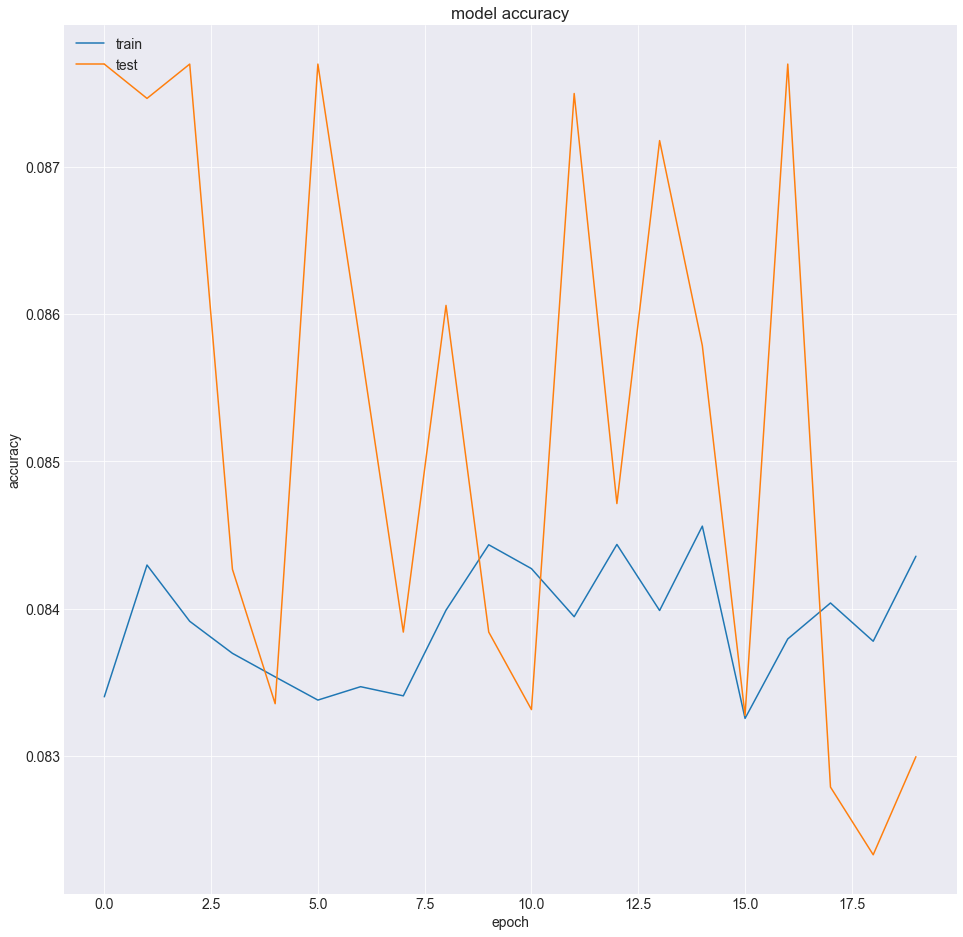

In [109]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [71]:
# Building the Convolutionals Model
model = Sequential()

# Set up some parameters
num_classes = 12
input_shape = (490, 40)

# Convert X_train and X_test to numpy array
max_review_length = 500 
X_train_CNN = sequence.pad_sequences(X_train, maxlen=max_review_length) 
X_test_CNN = sequence.pad_sequences(X_test, maxlen=max_review_length)


# First convolutional layer, note the specification of shape
model.add(Conv1D(32, kernel_size=10,
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv1D(64, 10, activation='relu'))
model.add(MaxPooling1D(pool_size=20,))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(X_train_CNN, nny_train,
          batch_size=128,
          epochs=10,
          verbose=1,
          validation_data=(X_test_CNN, nny_test))
score = model.evaluate(X_test_CNN, nny_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

ValueError: `sequences` must be a list of iterables. Found non-iterable: 2

# Unsupervised Learning

In [38]:
print(X.shape)
X.head()

(600000, 490)


,device_id,gender,age,is_active,label_id,2,4,6,7,8,...,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021
3181223,-5422222189097128376,1,23,0,710,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12465750,-1909840803012691378,1,23,0,719,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5864016,-3950380121994356121,1,25,0,549,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2574694,-691042505889609750,1,24,0,549,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2006630,-8010454263681268365,1,26,0,780,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [153]:
# Prepare for k-means X.
km_X = X_train
km_Xte = X_test
# Normalize
X_norm = normalize(km_X)
X_norm_test = normalize(km_Xte)

# Create the two-feature PCA for graphing purposes.
pca = PCA(n_components=2)
kmX_pca = pca.fit_transform(X_norm)
kmX_test_pca = pca.fit_transform(X_norm_test)

In [154]:
# Calulate predicted values
kmeans = KMeans(n_clusters=2, init='k-means++', random_state=42, n_init=20, n_jobs=-1)
y_pred = kmeans.fit_predict(kmX_pca)

pd.crosstab(y_train, y_pred)

col_0,0,1
row_0,,
F23-,18519,18857
F24-26,19636,17944
F27-28,18808,18772
F29-32,18180,19213
F33-42,18069,19278
F43+,18237,19382
M22-,18729,18874
M23-26,18696,18870
M27-28,19345,18290


In [155]:
from sklearn.metrics import adjusted_rand_score
print('Adjusted Rand Score: {:0.7}'.format(adjusted_rand_score(y_train, y_pred)))

Adjusted Rand Score: 8.065058e-05


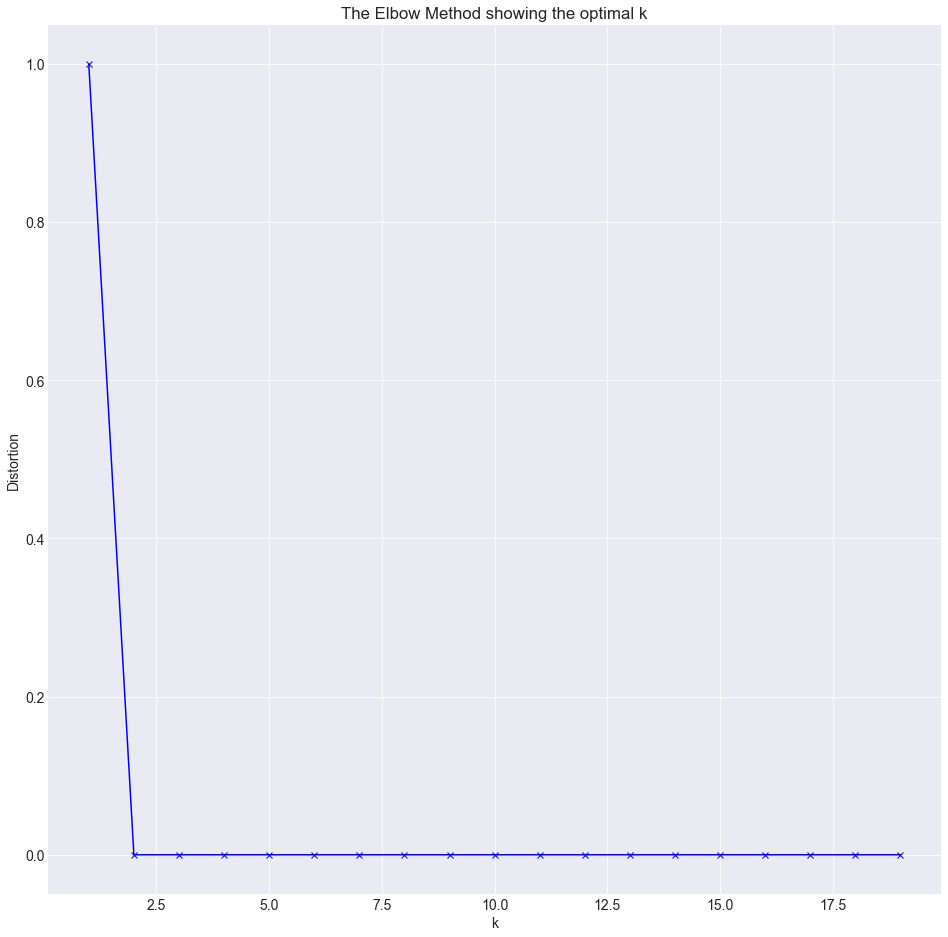

In [156]:
from scipy.spatial.distance import cdist
# Use the elbow method to see what is the optimal amount of clusters.

# k means determine k
distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(kmX_pca)
    kmeanModel.fit(kmX_pca)
    distortions.append(sum(np.min(cdist(kmX_pca, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / kmX_pca.shape[0])

# Plot the elbow
sns.set_style('darkgrid')
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [46]:
# Cluster Analysis
cluster_pred = KMeans(n_clusters=2, random_state=42, n_jobs=-1).fit_predict(X)
X_pred = X.copy()
X_pred['cluster_assignment'] = cluster_pred

cluster_dataframes = {}
for n_clust in range(3):
    cluster_dataframes[n_clust] = X_pred.loc[X_pred['cluster_assignment'] == n_clust]

for name, frame in cluster_dataframes.items():
    print(name)
    print('\n')
    print(frame.describe())

0


          device_id    gender            age      is_active       label_id  \
count  3.037450e+05  303745.0  303745.000000  303745.000000  303745.000000   
mean  -4.552825e+18       1.0      31.384859       0.289341     586.524634   
std    2.674008e+18       0.0       9.740515       0.453457     239.637685   
min   -9.222957e+18       1.0      11.000000       0.000000       6.000000   
25%   -6.851784e+18       1.0      25.000000       0.000000     405.000000   
50%   -4.522266e+18       1.0      29.000000       0.000000     704.000000   
75%   -2.255756e+18       1.0      35.000000       1.000000     756.000000   
max    7.684152e+16       1.0      86.000000       1.000000    1021.000000   

              2         4              6              7              8  \
count  303745.0  303745.0  303745.000000  303745.000000  303745.000000   
mean        0.0       0.0       0.000020       0.000013       0.000211   
std         0.0       0.0       0.004444       0.003629       0.014514 

In [185]:
# Turn the clusters into a data frame. 
df_y = pd.DataFrame(y_pred)
df_y.columns = ['Cluster']
df_y.head()

,Cluster
0,0
1,0
2,0
3,0
4,0


In [186]:
# Attach clusters to the data frame.
clustered_x = X.join(df_y, how='inner')

clustered_x.head()

,device_id,gender,age,is_active,encoded_model,label_id,2,4,6,7,...,1013,1014,1015,1016,1017,1018,1019,1020,1021,Cluster
50,4512601534898387785,1,30,0,731,704,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
70,6927084994051042878,1,21,0,856,548,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
74,5162181496749330558,1,25,0,857,704,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
94,-854334950563800171,0,21,0,387,548,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
96,-3775758989316758693,1,30,0,848,713,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [187]:
# Create age method.

def age_bucket(age):
    output = ''
    if age <=20:
        output = 'Under 20'
    elif (age > 20 and age <= 30):
        output = 'Between 20 and 30'
    elif (age > 30 and age <= 40):
        output = 'Between 30 and 40'
    elif (age > 40 and age <= 50):
        output = 'Between 40 and 50'
    elif (age > 50 and age <= 60):
        output = 'Between 50 and 60'
    else:
        output = 'Over 60'
    
    return output

In [188]:
# Apply the method I just wrote. 
clustered_x['Age Bucket'] = clustered_x['age'].apply(lambda x: age_bucket(x))

<Figure size 1152x576 with 0 Axes>

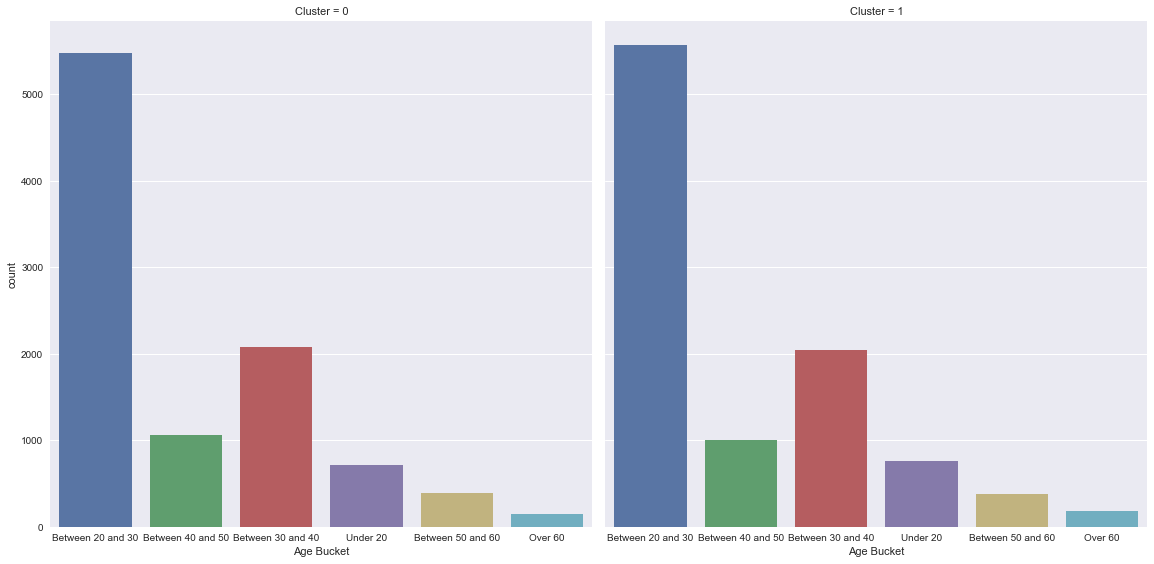

In [194]:
# Look at Age Breakdown for Count
plt.figure(figsize=(16,8))
sns.set(font_scale=1);
sns.factorplot(x='Age Bucket', col='Cluster', kind="count", data=clustered_x, size=8);

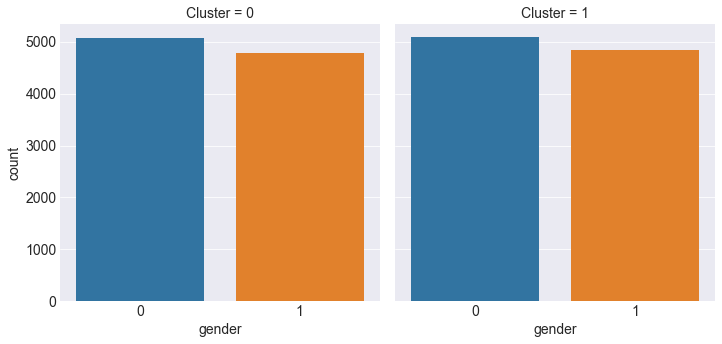

In [162]:
# Take a look at gender
sns.factorplot(x='gender', col='Cluster', kind="count", data=clustered_x, size=5)

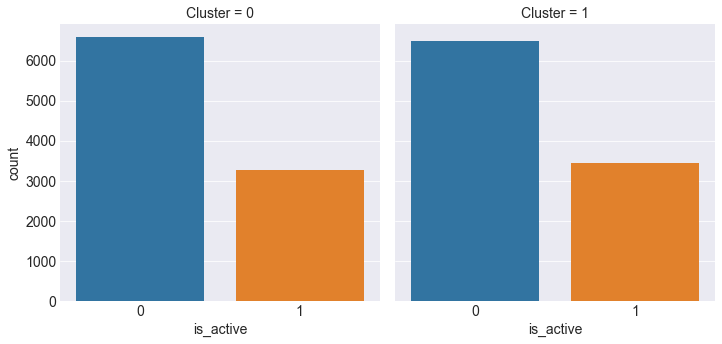

In [163]:
# Take a look at is_active
sns.factorplot(x='is_active', col='Cluster', kind="count", data=clustered_x, size=5)

# Current Issues.

- Improving the logistic classification model has proved difficult. I have applied PCA but to no avail.
- I applied PCA and selectKBest to the random forest model. Random forest improved .02% while selectKbest did not improve.
- Working on keras neural network now. 
- I have increased layers, batch size, and epochs already, but I'm still capped at 8% accuracy. 
- Still have an error at the CNN.
- XGboost is now overfitting after i fixed an error. 

max_review_length = 500 X_train_CNN = sequence.pad_sequences(x_train, maxlen=max_review_length) X_test_CNN = sequence.pad_sequences(x_test, maxlen=max_review_length)